In [2]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import cPickle as pickle
import tensorflow as tf
import gym
from matplotlib import pyplot as plt
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
# gamma = 1-0.
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = True # resume from previous checkpoint?
# resume = False;
render = False
# render = True
backlen=20;


def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(xrange(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}
def lookback(lst):
    lst = lst[-backlen:];
#     np.pad(lst,(20-lst.size,), 'constant', constant_values=0);
    if len(lst) != backlen:
        lst = [None]*(backlen-len(lst)) + lst;
    return(lst)

def time_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    grad = 0;
    for t in reversed(xrange(0, r.size)):
#         grad = grad * gamma + r[t] ;
        if r[t] != 0: 
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            grad = 2 * (r[t] > 0) - 1; 
        running_add = running_add + grad;
        discounted_r[t] = running_add
    return discounted_r


* Initiliase topology
* set input and output
* set optimiser
* set routine


In [5]:
# model initialization
resume = 1;
# resume = True;
render = False;
render = True;
H=5;
k=4;
gamma = 0.99;
D1=80;D2=80;
D = 80 * 80 # input dimensionality: 80x80 grid

In [34]:
del model

In [3]:
# tf.reset_default_graph()

from keras.layers import Input, Dense, convolutional,core,concatenate,Flatten
from keras.models import Model,load_model
from keras.models import model_from_json
from keras import backend as K
import keras

def quickax():
    fig = plt.figure(figsize=[8,8])
    ax1 = fig.add_subplot(221)
    return ax1
def savemodel(m,ModelFile):
    # serialize model to JSON
    model_json = m.to_json()
    with open(ModelFile+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(ModelFile+'.h5')
    pickle.dump(losshist,open(ModelFile+'.p', "wb"))
    print("Saved model to disk at "+ModelFile)
# savemodel(model,ModelFile)

# load json and create model
def loadmodel(ModelFile):
    global losshist,episode_number
    json_file = open(ModelFile+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(ModelFile+'.h5')
#     print("Saved model to disk at "+ModelFile)
    losshist = pickle.load(open(ModelFile+'.p', 'rb'))
    episode_number = len(losshist.losses);
    print("Model loaded from disk at "+ModelFile)
    return(loaded_model)
# model = loadmodel(ModelFile)
class LossCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
class LossHist():
    def __init__(self):
        self.losses=[];
    def add(self,n,loss):
        l = len(self.losses);
        if n == l+1:
            self.losses.append(loss);
        else:
            self.losses += [0]*(n-l);
            self.losses = self.losses[:n];
            self.losses[n-1] = loss;
            print('Loss history has changed ')
    def vis(self,ax):
        ax.plot(self.losses,'-');
        pass

def lossfunc(y_true,y_pred):
    return K.mean(K.mean( K.square( y_pred / (K.abs(y_true)+1) - 1)  )); 
# tpr=time_epr;
def decouple(tpr):
    tpr1=np.maximum(tpr,0);
    tpr2=np.minimum(tpr,0);
    tpr1[tpr1==0]=np.maximum(np.max(tpr1),20);
    tpr2[tpr2==0]=np.minimum(np.min(tpr2),-20);
    tpr2=-tpr2;
    time_epr = np.hstack([tpr1,tpr2])
    return(time_epr)


Using TensorFlow backend.


In [6]:
x_input = Input(shape=(D1,D2,1,))
po_input = Input(shape=(1,));
conv1 = convolutional.Conv2D(filters=H,
                             kernel_size=(k,k),
                            strides=(1,1),
                            padding='same',
                            activation='relu')(x_input)
den1 = Flatten()(Dense(units=5*H,
             activation='relu')(conv1))

den1c = concatenate([den1,po_input]);
score = Dense(units=2,
              activation = 'relu')(den1c)

model = Model(inputs=[x_input,po_input], outputs=[score])

optimiser = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer='rmsprop',
              loss=lossfunc)
history = LossCallback()
# log = model.fit([epx,epy], time_epr,callbacks=[history])
# loss = model.train_on_batch([epx,epy], time_epr)
# print(history.losses[-1])
# x = Dense(64, activation='relu')(x_input)

In [65]:
# xinput.shape
del model
del losshist

(0, 1.0300502315163613)

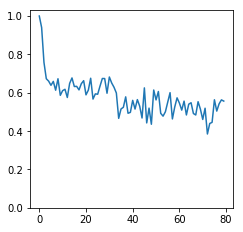

In [88]:
# losshist_temp=losshist;

ax = quickax();
losses = losshist.losses;
losshist = LossHist();
losshist.losses = losses;
losshist.vis(ax);
ax.set_ylim(bottom=0)

80

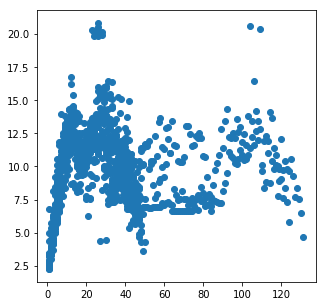

In [89]:
# discount_rewards(epdlogp)
x.size
%matplotlib inline
plt.close('all')
fig=plt.figure(figsize=[5,5])
ax1=plt.subplot()
# ax1.plot(time_epr)
# ax1.plot(discounted_epr)
ax1.scatter(abs(time_epr),eptpred)
# ax1.set_xlim([0, 200])
# ax1.set_xlim([800, 1000])
# ax1.set_ylim([-10, 000])
# ax1.imshow(eph[:500,:500].T)
time_epr.size
# tpreds.size
D1



In [ ]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
ys=[];byss=[];rss=[];tpreds=[];
running_reward = None
reward_sum = 0
episode_number = 0;

ModelName = 'H5k4_RL_pong_RMSprop_accumulloss_2event'
ModelFile = 'Models/'+ModelName+'.ckpt';
render = False;
resume = 1;
batch_size=1;
learning_rate = 1e-2
optimiser = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
# episode_number = 0;

if 'losshist' in locals():
    pass
else:
    losshist = LossHist();

while True:
    if resume:
        model = loadmodel(ModelFile)    
#         losshist=losshist_temp;
        
    model.compile(optimizer='rmsprop',
                  loss=lossfunc)
    while True:
        if render: env.render()

        # preprocess the observation, set input to network to be difference image
        cur_x = prepro(observation)
        diff_x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
        x = np.reshape(diff_x,[1,D1,D2,1]);
        
        # Sample action and label it 
        aprob = 0.5;
        action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
        y = 1 if action == 2 else 0 # a "fake label"
        
        # Run predictor
        tpred = model.predict([x,np.array([[y]])]);
#         tpred = model.predict({'input_1':x,'input_2':np.array([[y]])});
        
    
        # record various intermediates (needed later for backprop)
        xs.append(x) # observation
        ys.append(y)
        tpreds.append(tpred);
#         spreds.append(spred);

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
        

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys);
            epr = np.vstack(drs)
            eptpred=np.vstack(tpreds);
#             epspred=np.vstack()
            xs,hs,dlogps,drs,ys,tpreds = [],[],[],[],[],[] # reset array memory
            
#             time_epr=time_rewards(epr);
            tpr=time_rewards(epr);
            time_epr = decouple(tpr);
            
            
            curr_loss = model.train_on_batch([epx,epy], time_epr)
            losshist.add(episode_number,curr_loss);
            
            if episode_number % batch_size == 0:
                #accumulate gradient over batch where appropriate
                pass
   
            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print 'resetting env. episode %d reward total was %f. loss_func: %f' % (episode_number, reward_sum, curr_loss)
            if episode_number % 10  == 9: 
                savemodel(model,ModelFile)

            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None
            #     print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

[2017-06-05 18:26:41,899] Making new env: Pong-v0


Model loaded from disk at Models/H5k4_RL_pong_RMSprop_accumulloss_2event.ckpt
resetting env. episode 90 reward total was -21.000000. loss_func: 0.225661
resetting env. episode 91 reward total was -21.000000. loss_func: 0.539773
resetting env. episode 92 reward total was -21.000000. loss_func: 0.234752
resetting env. episode 93 reward total was -19.000000. loss_func: 0.663639
resetting env. episode 94 reward total was -21.000000. loss_func: 0.212461
resetting env. episode 95 reward total was -21.000000. loss_func: 0.273226
resetting env. episode 96 reward total was -21.000000. loss_func: 0.204887
resetting env. episode 97 reward total was -21.000000. loss_func: 0.141673
resetting env. episode 98 reward total was -20.000000. loss_func: 0.544682
resetting env. episode 99 reward total was -21.000000. loss_func: 0.254858
Saved model to disk at Models/H5k4_RL_pong_RMSprop_accumulloss_2event.ckpt
resetting env. episode 100 reward total was -21.000000. loss_func: 0.175006
resetting env. episod

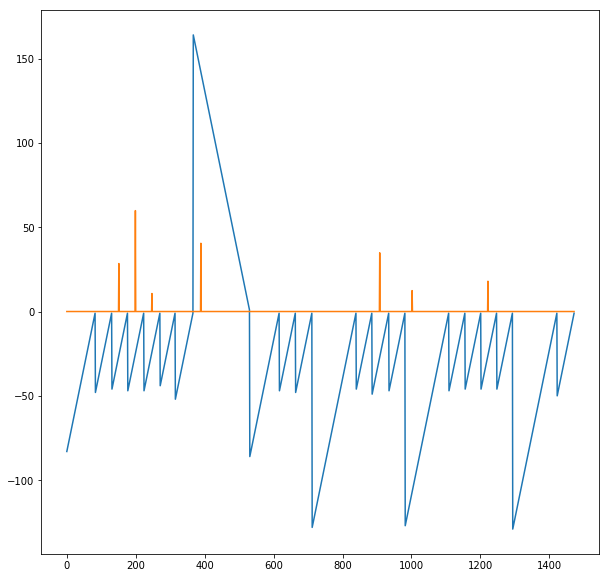

In [21]:
# discount_rewards(epdlogp)
x.size
%matplotlib inline
plt.close('all')
fig=plt.figure(figsize=[10,10])
ax1=plt.subplot()
ax1.plot((time_epr))
ax1.plot(eptpred[:,0])
ax1.plot(eptpred[:,1])

# ax1.plot(np.sign(-(epspred-.5))*2*(eptpred-1))


# ax1.plot(discounted_epr)
# ax1.scatter(abs(time_epr),eptpred)
# ax1.set_xlim([0, 500])
# ax1.set_xlim([500, 1000])
# ax1.set_ylim([-0, 50])


# ax1.imshow(eph[:500,:500].T)
# tpreds.size


In [19]:
# print(time_epr.ravel())
# time_epr
# tpreds
# H
# np.expand_dims(epx,1).shape
# curr_loss = sess.run(loss,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
# epx.shape
# tf.reshape(epy);
# D*H
# oSaver = tf.train.Saver()
print(sess.run(score,feed_dict={xinput: epx, input_y: epy, rtime: time_epr}))
# oSess = sess
# oSaver.save(oSess, ModelFile)

[[ nan]
 [ nan]
 [ nan]
 ..., 
 [ nan]
 [ nan]
 [ nan]]
